In [1]:
import numpy as np
import astropy.units as u
from astropy.time import Time
from astropy.table import Table
from sbpy.data import Ephem, Phys
from sbpy.activity import (Haser, LTE, NonLTE, photo_timescale, einstein_coeff, 
intensity_conversion, beta_factor, total_number, from_Haser)
import matplotlib.pyplot as plt
import matplotlib
import astropy.constants as con

Calculating Production Rate using `sbpy.activity.gas` Haser model
===================================
____________________________________________________________________________________________________________________

Another model included sbpy for the calculation of production rates is based off of [Haser 1957](https://ui.adsabs.harvard.edu/abs/1957BSRSL..43..740H/abstract).

This model takes in an initial guess for the production rate, and uses the [`sbpy.activity.Haser`](https://sbpy.readthedocs.io/en/latest/api/sbpy.activity.Haser.html#sbpy.activity.Haser) class instance to obtain a final value. The LTE production rate function `from_Haser` obtains a total number of molecules from `sbpy.activity.Haser` based on a first guess of the production rate (this is where `from_Drahus` comes in handy). Then the function takes a total number of molecules given by the user, and uses a ratio relationship to obtain the optimized production rate: 

$$Q = Q_{guess} \frac{totalnum_{from \: user}}{totalnum_{from \: guess}}$$

The user can either define their chosen column density and total number of molecules, or they can calculate it from their data or JPLSpec data using `sbpy.activity.LTE` `cdensity_Bockelee` and `sbpy.activity.total_number`, which are calculations based on **eq. 10** from [Bockelee-Morvan et al. 2004](https://ui.adsabs.harvard.edu/#abs/2004come.book..391B). The literature used for this example is from [Wierzchoz 2018](https://ui.adsabs.harvard.edu/abs/2018AJ....156...34W/abstract).
____________________________________________________________________________________________________________________

Load the data file containing values for time of observations, integrated flux, 
and error bars from the literature in order to obtain the 
information needed for the calculation of our production rates

In [2]:
co = Table.read(('data/CO.csv'), format="ascii.csv")
error = np.array([0.2, 0.4, 0.4, 0.4, 0.4]) * 10.**28 # +/- error from literature
Q_error = np.array(co['Q']) + np.array(error) # upper error limit
Q_error = np.log10(np.array(Q_error)) - np.array(co['log(Q)'])
co['Q_error'] = Q_error
print("Table:\n{}\nColumn Names:\n{}".format(co, co.columns))

Table:
     U_T              Time        T_B     Q       log(Q)         Q_error       
------------- ------------------- ---- ------- ----------- --------------------
2017-12-22.21 2017-12-22 05:02:24 0.26 4.4e+28 28.64345268 0.019305151681574984
2017-12-23.09 2017-12-23 02:09:36 0.28 4.6e+28 28.66275783  0.03621217433601842
2017-12-30.14 2017-12-30 03:21:36 0.26 4.6e+28 28.66275783  0.03621217433601842
2017-12-31.13 2017-12-31 03:07:12 0.27 4.6e+28 28.66275783  0.03621217433601842
2018-01-16.03 2018-01-16 00:43:12 0.27 4.6e+28 28.66275783  0.03621217433601842
Column Names:
<TableColumns names=('U_T','Time','T_B','Q','log(Q)','Q_error')>


Model parameters needed, all values are taken directly from the literature.
In this example the molecule identifier will be inputted as a regular expression. 
Regular expressions for mol_tag can be used but the user must be careful not to provide
an ambiguous regular expression. One good thing to remember is that anything between symbols '^' and '\\$'
will be matched exactly, therefore you can avoid an ambiguity error by writing your molecule name as such:
'^name\\$'. A perfect example of this is with the molecule in this example 'CO', simply writing mol_tag = 'CO'
will produce an ambiguity error because it will match CO, CO2, etc. therefore, it is necessary to 
restrict our molecule name regex to '^CO\\$' as presented below.

In [3]:
transition_freq = (230.538 * u.GHz).to('MHz')

aper = 10 * u.m # aperture

mol_tag = '^CO$' # regex molecule identifier

temp_estimate = 25. * u.K 

vgas = 0.5 * u.km / u.s

target = 'C/2016 R2'

b = 0.74 # intrinsic antenna value

Obtaining molecular data from the JPL Molecular Spectroscopy Catalog using `sbpy.data.phys`. 
See documentation for a detailed breakdown of the resulting object and the values stored in the object.

In [4]:
mol_data = Phys.from_jplspec(temp_estimate, transition_freq, mol_tag) # molecular data from JPLSpec

intl = intensity_conversion(mol_data) # calculate line intensity

mol_data.apply([intl.value] * intl.unit,
                    name='Integrated line intensity at desired temp') # store value

Obtaining the Einstein Coefficient. In this example, we will obtain our Einstein Coefficient from
LAMDA catalog and append it to our molecular data Phys object. In the previous exammples we have been calculating it through sbpy/JPLSpec. It is possible that your transition frequency values may not exactly match the LAMDA catalog to the 4th significant figure, especially if you're using JPLSpec. Therefore, we recommend when using this method
that you match your transition frequency with the LAMDA value over the JPLSpec value, since from_jplspec is
designed to pick the closest transition frequency within a range of 1 GHz, whereas LAMDA will expect the
exact value found in their catalog.

In [5]:
from astroquery.lamda import Lamda

mol_name = 'CO' # LAMDA molecule name

lam_search = Lamda.query(mol=mol_name.lower()) # LAMDA Query

lam_result = lam_search[1] # outputs CO table

lam_found = lam_result[lam_result['Frequency'] == transition_freq.to('GHz').value] # parse results at frequency

au_cat = lam_found['EinsteinA'] # get Einstein Coefficient

au_cat = au_cat.data[0] # get value of coefficient

au = au_cat / u.s # define the unit

mol_data.apply([au.value] * au.unit, name='eincoeff') # store einstein coefficient

/Users/gianni0603/anaconda/lib/python3.6/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


Initialize the `sbpy.activity.Haser` model in order to perform our production rate calculations. 
`Q_estimate` first guess for the production rate was obtained running `from_Drahus` for the same data set before doing this example

In [6]:
Q_estimate = 3.594*10**(28) / u.s 

parent = photo_timescale('CO') * vgas # parent photodissociation rate

coma = Haser(Q_estimate, vgas, parent) # initializing the model with an estimate 

Since our data file contains 6 different data points of observation times and integrated flux, we can
calculate production rates for all of these 6 data points using a python for loop.

The `beta_factor` function is only necessary if the user will be using the `total_number_nocd` function, if 
the user chooses to define their total number of molecules by any other means, or calculate it by any other 
means then the `beta_factor` is not a necessary calculation. In order to understand how to user-define the 
total number, refer to previous sections in which user-defined values are appended to the `mol_data` phys object.

**IMPORTANT: Because we are using a for loop, and some of the values that should be appended to the `mol_data`
phys object are calculated within the loop itself, we must initialize our columns within the phys object
BEFORE performing the loop. This is because you cannot iteratively redefine the same column of data within a 
phys object, but you CAN change the value of an already defined column as many times as you want.
Since our `beta`, `cdensity` and `total_number` values vary with every iteration,
and since our production rate needs these values within the loop, we must simply change the value of our
already defined columns for beta, column density, and total number everytime we iterate. Keep in mind when you initialize the column you must initialize it with the correct units and correct type (float, int, str). If you get an error saying there are duplicate columns, it is most likely due to what has been mentioned in this note, and you will have to reinitialize your mol_data object before trying to enter more data in**

In [7]:
mol_data.apply([1.] * u.AU * u.AU * u.s, name='beta') # initialize beta factor column
mol_data.apply([1.] * u.km / (u.m * u.m * u.m), name='cdensity') # initialize column density column
mol_data.apply([1.], name='total_number') # initialize total number column

q_found_co = [] # define empty list

lte = LTE() # initialize LTE class

for i in range(0, 5):

    time = Time(co['Time'][i], format='iso')
    
    integrated_flux = co['T_B'][i] * u.K * u.km / u.s
    
    ephemobj = Ephem.from_horizons(target, epochs=time.jd)
    
    beta = beta_factor(mol_data, ephemobj) # calculate beta factor
    
    mol_data['beta'] = beta # redefine column value for beta
    
    cdensity = lte.cdensity_Bockelee(integrated_flux, mol_data)
    
    mol_data['cdensity'] = cdensity 
    
    tnum = total_number(mol_data, aper, b) # calculate total number

    mol_data['total_number'] = tnum # redefine column value for total number

    Q = from_Haser(coma, mol_data, aper=aper) # calculate production rate

    q_found_co.append(np.log10(Q.value)[0]) # append production rate

print("The Resulting Production Rates for CO in {} using Haser model are:\n {}".format(target, np.round(q_found_co,3)))

The Resulting Production Rates for CO in C/2016 R2 using Haser model are:
 [27.979 28.01  27.968 27.983 27.961]


Plot Production Rates against Time

The Literature Production Rates for CO in C/2016 R2 using Wierzchos & Womack 2018 are:
 [28.643 28.663 28.663 28.663 28.663]


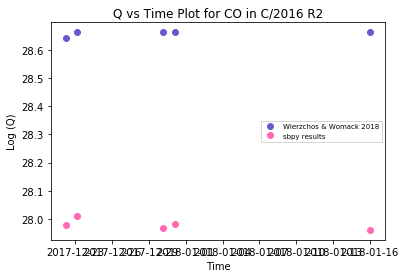

In [8]:
q_pred_co = list(co['log(Q)']) # literature production rates
print("The Literature Production Rates for CO in {} using Wierzchos & Womack 2018 are:\n {}".format(target, np.round(q_pred_co,3))) 

time_co = list(co['Time'])
time_co = matplotlib.dates.datestr2num(time_co)

plt.plot_date(time_co, q_pred_co, 'o', color='slateblue', label='Wierzchos & Womack 2018')
plt.plot_date(time_co, q_found_co, 'o', color='hotpink', label='sbpy results')
plt.xlabel('Time')
plt.ylabel('Log (Q)')
plt.legend(loc='best', fontsize='x-small')
plt.title('Q vs Time Plot for CO in {}'.format(target))
plt.show()

Calculate residuals:

The Residuals between sbpy results and literature are:
 [0.664 0.653 0.695 0.68  0.702]


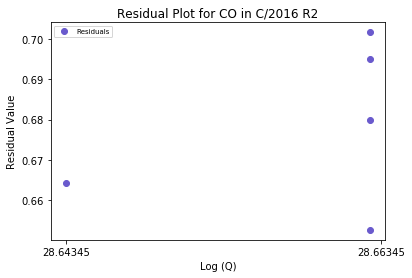

In [9]:
q_pred_co = list(co['log(Q)']) # literature production rates

res_co = (np.array(q_pred_co)) - (np.array(q_found_co)) # residuals

print("The Residuals between sbpy results and literature are:\n {}".format(np.round(res_co,3))) 

plt.plot(q_pred_co, res_co, 'o', color='slateblue', label='Residuals') # plot
plt.xlabel('Log (Q)')
plt.ylabel('Residual Value')
plt.legend(loc='best', fontsize='x-small')
plt.title('Residual Plot for CO in {}'.format(target))
plt.xticks(np.arange(min(q_pred_co), max(q_pred_co)+0.003, 0.02))
plt.show()


In [10]:
print("Production rate + error\n{}\nResiduals from sbpy\n{}".format(list(np.round(co['Q_error'],3)), np.round(res_co,3)))

Production rate + error
[0.019, 0.036, 0.036, 0.036, 0.036]
Residuals from sbpy
[0.664 0.653 0.695 0.68  0.702]


It is noticeable that for this model the difference between the literature and sbpy is a little bigger. We have not been in contact with the authors of this paper as we have for the previous examples. Since it is not clear exactly what parameters the paper used, we can only infer where the differences come from. Since this model is driven by the ratio of total number of molecules from data calculation vs from the Haser model, it is possible the discrepancies are coming from parameters related to our `total_number` function. Since the literature does offer an average value for the column density of CO, we calculate the results again, using our model, based on this information.

In [11]:
column_density = (1.89*10.**(14) / (u.cm * u.cm)).to(1/(u.m* u.m)) # average from literature
mol_data.apply([column_density.value] * column_density.unit, 'Column Density')
q_found_co = []

for i in range(0, 5):

    time = Time(co['Time'][i], format='iso')
    
    integrated_flux = co['T_B'][i] * u.K * u.km / u.s
    
    ephemobj = Ephem.from_horizons(target, epochs=time.jd)
    
    beta = beta_factor(mol_data, ephemobj) # calculate beta factor
    
    mol_data['beta'] = beta
    
    tnum = total_number(mol_data, aper, b)

    mol_data['total_number'] = tnum # redefine column value for total number

    Q = from_Haser(coma, mol_data, aper=aper) # calculate production rate

    q_found_co.append(np.log10(Q.value)[0]) # append production rate

print("The Resulting Production Rates for CO in {} using Haser model are:\n {}".format(target, np.round(q_found_co,3)))
print("Residuals:\n{}".format(np.round((np.array(q_pred_co)) - (np.array(q_found_co)),3)))
print("Literature errors:\n{}".format(np.round(co['Q_error'],3)))

The Resulting Production Rates for CO in C/2016 R2 using Haser model are:
 [27.996 27.994 27.984 27.983 27.961]
Residuals:
[0.648 0.668 0.679 0.68  0.702]
Literature errors:
[0.019 0.036 0.036 0.036 0.036]


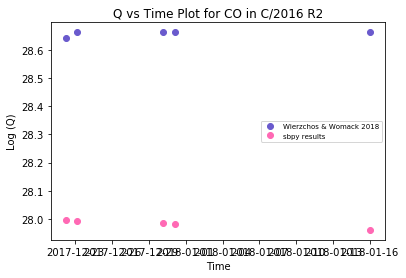

In [12]:
plt.plot_date(time_co, q_pred_co, 'o', color='slateblue', label='Wierzchos & Womack 2018')
plt.plot_date(time_co, q_found_co, 'o', color='hotpink', label='sbpy results')
plt.xlabel('Time')
plt.ylabel('Log (Q)')
plt.legend(loc='best', fontsize='x-small')
plt.title('Q vs Time Plot for CO in {}'.format(target))
plt.show()

This clearly shows that the column density calculation within our total_number function 
brought forward the biggest discrepancy in the model vs the literature. The column density equation used 
by sbpy is found in [Bockelee-Morvan et al. 2004](Bockelee-Morvan et al. 2004, Comets II, University of Arizona Press, Tucson, 745 pp., p.391-423). Of the free parameters we have, the column density equation depends on the Einstein Coefficient, the integrated flux, and the transition frequency. Our discrepancy then could lie in the source of the Einstein Coefficient, since the literature we are comparing against does not make mention of how the Einstein Coefficient was obtained. It is unlikely the cause is in the integrated flux or the transition frequency since those were plugged in directly from the literature. The other way that a discrepancy could be presenting itself is in the way that the column density was obtained. As mentioned above, we obtain the column density from the equation in Bockelee-Morvan et al. 2004 yet, the authors cite other models for their calculation of column density, which could also explain some of the discrepancy we see here.

Hardly traceable inconsistencies like these are common in cometary studies, since a lot depends on the molecular catalogs that the data is obtained from, or what calculations are used. This is exactly why sbpy offers flexibility in all its functions through the use of `sbpy.data` classes, which allow the user to define their preferrred parameters if they do not happen to be satisfied with the catalog functionalities and derivations of parameters that sbpy offers. Yet we recommend the use of as many sbpy functionalities as possible in order to maintain consistency in your calculations, which may prove to be important when conversations about comet classification arise. 

As detailed above, column density can have a significant effect on the accuracy of our measurements. While `cdensity_Bockelee` offers a good enough threshold for the column density, it is an LTE implementation and therefore not as accurate as the NonLTE method described in [this notebook](NonLTE_prodrate_Haser.ipynb).

Helpful Links
=======
___________________________________________

Relevant Notebooks
-----------------
- [How to calculate LTE production rates without photolysis effects](LTE_prodrate_without_photolysis.ipynb)
- [How to calculate NonLTE production rates with Haser model](NonLTE_prodrate_Haser.ipynb)
- [How to use Phys data class and `from_jplspec`](../data/Phys.ipynb)
- [What is `astroquery.jplspec`](../data/jplspec.ipynb)

Relevant Links
-------------
- [LAMDA Queries with astroquery](https://astroquery.readthedocs.io/en/latest/lamda/lamda.html)
- [JPLSpec Queries with astroquery](https://astroquery.readthedocs.io/en/latest/jplspec/jplspec.html)
- [sbpy Activity Haser Class](https://sbpy.readthedocs.io/en/latest/api/sbpy.activity.Haser.html#sbpy.activity.Haser)
- [sbpy Ephem data class](https://sbpy.readthedocs.io/en/latest/sbpy/data/index.html#how-to-use-ephem)
- [sbpy Phys data class](https://sbpy.readthedocs.io/en/latest/sbpy/data/index.html#how-to-use-phys)
- [sbpy data class alternative field names](https://sbpy.readthedocs.io/en/latest/sbpy/data/fieldnames.html#list-of-alternative-field-names)
- [pyradex source code](https://github.com/keflavich/pyradex)
- [RADEX fortran source code](https://personal.sron.nl/~vdtak/radex/)
- [RADEX homepage](https://personal.sron.nl/~vdtak/radex/index.shtml)
- [sbpy citation (please cite our work)](http://joss.theoj.org/papers/10.21105/joss.01426)